In [1]:
import numpy as np
import sys
import keras.preprocessing.image 
from keras.models import Sequential,Model,load_model
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense,  GlobalMaxPooling2D
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from keras.layers import Input
import csv
import pandas as pd   
import os
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [34]:
#Global Variables
WANTED_BANDS = [3, 2, 1]
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS, NUM_OG_BANDS = (64, 64, len(WANTED_BANDS), 13) 
MODEL_NAME = "CNN-({})input-({}, {}, {})".format("Resnet50", IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS)
PATH = "/atlas/u/{}/data/kiln-scaling/models/{}/".format(sys.argv[0], MODEL_NAME) 
DATA_PATH = "/atlas/u/mhelabd/data/kiln-scaling/tiles/"
MODEL_WEIGHTS_PATH = PATH + "weights/"
MODEL_HISTORY_PATH = PATH + "history/"
VERBOSE = True
BALANCE_DATASET = True
RANDOM_STATE = 42

In [35]:
def load_data_from_h5(preprocess=False, verbose=VERBOSE, balance_dataset=BALANCE_DATASET):
    X, y = [], []
    for i, filename in enumerate(os.listdir(DATA_PATH)):
        print("extracting: ",filename) 
        with h5py.File(DATA_PATH + filename, "r") as f:
            if i == 0:
                X = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                X = np.moveaxis(X, 1, -1)[:, :, :, WANTED_BANDS]
                y = np.array(f["labels"][()])
            else:
                x_i = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                x_i = np.moveaxis(x_i, 1, -1)[:, :, :, WANTED_BANDS]
                X = np.concatenate((X, x_i))
                y_i = np.array(f["labels"][()])
                y = np.concatenate((y, y_i))

        if balance_dataset:
            #since y = 1 is always less
            n= y[y==1].shape[0]
            mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False)
                              for l in np.unique(y)])
            X = X[mask]
            y = y[mask]
        
    if preprocess:
        X = preprocess_input(X)

    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y

In [4]:
def load_data_from_csv(preprocess=True, verbose=VERBOSE):
    for i in range(24):
        if i == 0:
            x_pos = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
        else:
            x_pos_i = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_pos = np.concatenate((x_pos, x_pos_i))
            x_neg_i = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.concatenate((x_neg, x_neg_i))
    if verbose:
        print("x_pos.shape: ", x_pos.shape)
        print("x_neg.shape: ", x_neg.shape)
    if preprocess:
        x_pos = preprocess_input(x_pos)
        x_neg = preprocess_input(x_neg)

    X = np.concatenate((x_pos, x_neg))    
    # y is a vector of ones (kilns present) and zeros (kilns absent)
    y = np.concatenate((np.ones(len(x_pos)), np.zeros(len(x_neg) ) )).reshape(-1, 1)
    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y
    

In [5]:
def split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2):
    assert train_percent + val_percent + test_percent == 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, random_state=RANDOM_STATE)
    updated_val_precent = val_percent/(1 - test_percent)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=updated_val_precent, random_state=RANDOM_STATE)
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [7]:
def make_model(weights="imagenet", 
               include_top=False, 
               load_weights=None, # path of weights
               loss=keras.losses.binary_crossentropy, 
               optimizer=keras.optimizers.Adam(), 
               metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)]):
    
    image_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
    base_model = ResNet50(include_top=include_top, weights=weights, input_tensor=image_input, classes=2)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(1024,activation='relu')(x) 
    x = Dense(1024,activation='relu')(x) 
    x = Dense(512,activation='relu')(x) 
    x = Dense(1, activation= 'sigmoid')(x)
    model = Model(inputs = base_model.input, outputs = x)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    if load_weights:
        model.load_weights(load_weights)
    return model


In [8]:
def train_model(model, 
                X_train, 
                y_train,
                X_val,
                y_val,
                trial_name, 
                epochs=20,
                batch_size=64,
                multiprocessing=True, 
                early_stopping=False, 
                save_history=True):
    
    callbacks = []
    
    if early_stopping:
        early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
        callbacks.append(early_stop)
    checkpoint_file = MODEL_WEIGHTS_PATH + "{}.h5".format(trial_name)
    checkpoint = ModelCheckpoint(checkpoint_file, 
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)
    callbacks.append(checkpoint)                        
    
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs, 
                        batch_size=batch_size, 
                        use_multiprocessing=multiprocessing, 
                        validation_data=(X_val, y_val), 
                        callbacks=callbacks)
    if save_history:
        with open(MODEL_HISTORY_PATH + trial_name, 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    return model, history

In [9]:
def graph_model_performance(history):
  # IF METRICS ARE UPDATED, YOU MUST UPDATE THIS
  # summarize history for accuracy
  plt.plot(list(history['binary_accuracy']))
  plt.plot(list(history['val_binary_accuracy']))
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(list(history['loss']))
  plt.plot(list(history['val_loss']))
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [10]:
def print_images(x):
  normalized_x = x/np.max(x)
  plt.imshow(normalized_x)
  plt.show()
def evaluate_dataset(model, X, y, threshold=0.5, pictures=True):
  # Evaluate the model on the test data using `evaluate`
  results = model.evaluate(X, y, batch_size=128)
  print(dict(zip(model.metrics_names, results)))
  y_pred = model.predict(X) > threshold
  print(tf.math.confusion_matrix(y.reshape(-1), y_pred.reshape(-1)))
  if pictures:
    print("Generating three false positives...")
    false_positives = np.logical_and(y != y_pred, y_pred == 1)
    X_fp = X[false_positives.reshape(-1), :, :]
    for i in range(3):
      randi = np.random.randint(0, len(X_fp))
      print_images(X_fp[randi])
    print("Generating three false negatives...")
    false_negatives = np.logical_and(y != y_pred, y_pred == 0)
    X_fn = X[false_negatives.reshape(-1), :, :]
    for i in range(3):
      randi = np.random.randint(0, len(X_fn))
      print_images(X_fn[randi])
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, threshold=0.5, pictures=True):
  print("Evaluating Training data: ")
  evaluate_dataset(model, X_train, y_train, threshold=threshold, pictures=pictures)
  
  print("Evaluating Validation data: ")
  evaluate_dataset(model, X_val, y_val, threshold=threshold, pictures=pictures)

  print("Evaluating Training data: ")
  evaluate_dataset(model, X_test, y_test, threshold=threshold, pictures=pictures)
    

In [11]:
X, y = load_data_from_h5()

extracting:  examples_9.hdf5
extracting:  examples_30.hdf5
extracting:  examples_19.hdf5
extracting:  examples_28.hdf5
extracting:  examples_24.hdf5
extracting:  examples_15.hdf5
extracting:  examples_5.hdf5
extracting:  examples_11.hdf5
extracting:  examples_20.hdf5
extracting:  examples_1.hdf5
extracting:  examples_25.hdf5
extracting:  examples_14.hdf5
extracting:  examples_4.hdf5
extracting:  examples_10.hdf5
extracting:  examples_21.hdf5
extracting:  examples_0.hdf5
extracting:  examples_8.hdf5
extracting:  examples_31.hdf5
extracting:  examples_18.hdf5
extracting:  examples_29.hdf5
extracting:  examples_27.hdf5
extracting:  examples_16.hdf5
extracting:  examples_6.hdf5
extracting:  examples_12.hdf5
extracting:  examples_23.hdf5
extracting:  examples_2.hdf5
extracting:  examples_33.hdf5
extracting:  examples_32.hdf5
extracting:  examples_26.hdf5
extracting:  examples_17.hdf5
extracting:  examples_7.hdf5
extracting:  examples_13.hdf5
extracting:  examples_22.hdf5
extracting:  exampl

In [36]:
    for i, filename in enumerate(os.listdir(DATA_PATH)):
        print("extracting: ",filename) 
        with h5py.File(DATA_PATH + filename, "r") as f:
            if i == 0:
                X = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                X = np.moveaxis(X, 1, -1)[:, :, :, WANTED_BANDS]
                y = np.array(f["labels"][()])

extracting:  examples_9.hdf5
extracting:  examples_30.hdf5
extracting:  examples_19.hdf5
extracting:  examples_28.hdf5
extracting:  examples_24.hdf5
extracting:  examples_15.hdf5
extracting:  examples_5.hdf5
extracting:  examples_11.hdf5
extracting:  examples_20.hdf5
extracting:  examples_1.hdf5
extracting:  examples_25.hdf5
extracting:  examples_14.hdf5
extracting:  examples_4.hdf5
extracting:  examples_10.hdf5
extracting:  examples_21.hdf5
extracting:  examples_0.hdf5
extracting:  examples_8.hdf5
extracting:  examples_31.hdf5
extracting:  examples_18.hdf5
extracting:  examples_29.hdf5
extracting:  examples_27.hdf5
extracting:  examples_16.hdf5
extracting:  examples_6.hdf5
extracting:  examples_12.hdf5
extracting:  examples_23.hdf5
extracting:  examples_2.hdf5
extracting:  examples_33.hdf5
extracting:  examples_32.hdf5
extracting:  examples_26.hdf5
extracting:  examples_17.hdf5
extracting:  examples_7.hdf5
extracting:  examples_13.hdf5
extracting:  examples_22.hdf5
extracting:  exampl

In [38]:
np.where(y==1)

(array([  3,   5,  88,  99, 116, 182, 186, 190, 198, 209, 274, 330, 369,
        390, 481, 489, 645, 648, 679, 692, 700, 740, 846, 868, 915, 994,
        997]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]))

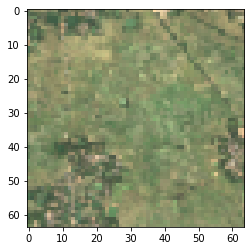

In [37]:
plt.imshow(X[3]/np.max(X[3]))

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2)
model = make_model()
model, history = train_model(model, X_train, y_train, X_val, y_val, "trial_1_epoch_40", epochs=4000, save_history=False)

Epoch 1/4000
27/27 [==============================] - 2s 68ms/step - loss: 2.5422 - binary_accuracy: 0.4909 - val_loss: 0.6935 - val_binary_accuracy: 0.4875
Epoch 2/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6939 - binary_accuracy: 0.4973 - val_loss: 0.6934 - val_binary_accuracy: 0.4875
Epoch 3/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6936 - binary_accuracy: 0.4949 - val_loss: 0.6934 - val_binary_accuracy: 0.4875
Epoch 4/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6956 - binary_accuracy: 0.4913 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 5/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6934 - binary_accuracy: 0.4913 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 6/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6937 - binary_accuracy: 0.4931 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 7/4000
27/27 [==============================] - 1s 3

Epoch 26/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 27/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 28/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6934 - val_binary_accuracy: 0.4875
Epoch 29/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 30/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6933 - binary_accuracy: 0.4997 - val_loss: 0.6935 - val_binary_accuracy: 0.4875
Epoch 31/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 32/4000
27/27 [==============================]

Epoch 51/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 52/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6934 - val_binary_accuracy: 0.4875
Epoch 53/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 54/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 55/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 56/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4740 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 57/4000
27/27 [==============================]

Epoch 76/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6931 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 77/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 78/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 79/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4937 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 80/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4967 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 81/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4913 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 82/4000
27/27 [==============================]

Epoch 101/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4907 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 102/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 103/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 104/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4806 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 105/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 106/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4907 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 107/4000
27/27 [========================

Epoch 126/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4794 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 127/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 128/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 129/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6931 - binary_accuracy: 0.5063 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 130/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 131/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 132/4000
27/27 [========================

Epoch 151/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6930 - val_binary_accuracy: 0.5125
Epoch 152/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 153/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 154/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4889 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 155/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 156/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 157/4000
27/27 [========================

Epoch 176/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 177/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 178/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6931 - binary_accuracy: 0.5003 - val_loss: 0.6930 - val_binary_accuracy: 0.5125
Epoch 179/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6930 - val_binary_accuracy: 0.5125
Epoch 180/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 181/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6930 - val_binary_accuracy: 0.5125
Epoch 182/4000
27/27 [========================

Epoch 201/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 202/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 203/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 204/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.5003 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 205/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4961 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 206/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 207/4000
27/27 [========================

Epoch 226/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 227/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 228/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 229/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6933 - val_binary_accuracy: 0.4875
Epoch 230/4000
27/27 [==============================] - 1s 38ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 231/4000
27/27 [==============================] - 1s 39ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.4875
Epoch 232/4000
11/27 [===========>............

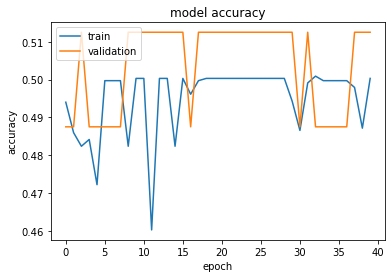

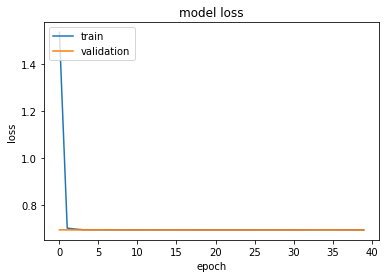

In [49]:
graph_model_performance(history.history)

In [50]:
evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)

Evaluating Training data: 
14/14 [==============================] - 0s 21ms/step - loss: 7.3508 - binary_accuracy: 0.4967
{'loss': 7.350840091705322, 'binary_accuracy': 0.49671250581741333}
tf.Tensor(
[[837   0]
 [836   0]], shape=(2, 2), dtype=int32)
Generating three false positives...


ValueError: low >= high